In [131]:
import numpy as np
import matplotlib.pyplot as plt

In [132]:
import math
def oned_pdf(x,mu,sigma):
    return (np.sqrt(2*np.pi*sigma**2)**-1)*math.exp(-0.5*((x-mu)/sigma)**2)
def pdf(x,mu,sigma,one_d=True):
    ## x and mu are column vectors here
    if(one_d):
        return oned_pdf(x,mu,sigma) 
    d = len(mu)
    sigma_inverse = np.linalg.inv(sigma)
    return(np.pow(2*np.pi,-d/2)*np.linalg.det(sigma)*np.exp((x-mu).T@sigma_inverse@(x-mu)))


from sklearn.cluster import KMeans
class gmm:
    def __init__(self,
                 datapoints,
                 n_clusters=3,
                 data_dim=1,
                 ):
        self.data_dim = data_dim
        if data_dim==1:
            ## kmeans initialization
            km = KMeans(n_clusters=n_clusters)
            km.fit(datapoints.reshape(-1,1))
            print("Global Variance : ",np.var(datapoints))
            print("Global Means : ",km.cluster_centers_)
            self.means = km.cluster_centers_.reshape(-1)
            self.stds = np.full(shape=(n_clusters),fill_value=np.var(datapoints.reshape(-1,1)))
            self.weights=np.full(shape=(n_clusters),fill_value=1/n_clusters)
            print(self.weights)
        else:
            self.means = np.random.rand(n_clusters, data_dim)
            self.stds = np.random.rand(n_clusters,data_dim , data_dim)
            self.weights = np.full(shape=(1,n_clusters),fill_value=1/n_clusters)
        self.datapoints = datapoints
        self.n_clusters= n_clusters
        
    def compute_responsibilities(self):
        probs = np.exp(-((self.datapoints -self.means[np.newaxis,:])**2)/(2*self.stds[np.newaxis,:]**2))/(np.sqrt(2*np.pi)*self.stds[np.newaxis,:])
        # probs = np.multiply(probs,self.weights[np.newaxis,:])
        # print(probs.shape)
        if(probs>1).any():
            raise ValueError("Probs greater than 1")
        responsibilities = np.multiply(probs,self.weights[np.newaxis,:])
        self.responsibilities = responsibilities/np.sum(responsibilities,axis=1)[:,np.newaxis]
        return 
    def update(self,thrs=1e-5):
        old_means = self.means.copy()
        self.compute_responsibilities()
        for k in range(self.n_clusters):
            n_k = self.responsibilities[:,k].sum()
            self.means[k] = np.sum(self.responsibilities[:,k].reshape(-1,1)*self.datapoints,axis=0)/n_k
            self.stds[k] =np.sqrt(np.sum(self.responsibilities[:,k].reshape(-1,1)*(self.datapoints-self.means[k])**2,axis=0)/n_k)
            self.weights[k] = n_k/self.datapoints.shape[0]
        print(f"Means : {self.means}")
        print(f"Stds : {self.stds}")
        if np.linalg.norm(old_means-self.means)<thrs:
            print(f"Magnitude of difference : {np.linalg.norm(old_means-self.means)}")
            return True
        else:
            print(f"Magnitude of difference : {np.linalg.norm(old_means-self.means)}")
            return False
    def fit(self,num_epochs=100,threshold=1e-5):
        print("Starting to fit")
        for i in range(num_epochs):
            if self.update(threshold):
                print(f"Converged after {i} epochs")
                break
            else:
                print(f"Epoch {i} done") 
    def get_cluster_assignments(self):
        return np.argmax(self.responsibilities,axis=1)
    def histogram(self):
        cluster_assignments = self.get_cluster_assignments()
        plt.hist(self.datapoints[cluster_assignments==0],bins=50,alpha=0.5)
        plt.hist(self.datapoints[cluster_assignments==1],bins=50,alpha=0.5) 
        plt.hist(self.datapoints[cluster_assignments==2],bins=50,alpha=0.5)
        plt.legend(["Cluster 1","Cluster 2","Cluster 3"])
        plt.title("Histogram of My GMM")
        plt.show()
            
        

In [ ]:
import nibabel as nib
data_matrix = nib.load("brain_data/sald_031764_img.nii").get_fdata()
# data_matrix =  data_matrix[data_matrix!=0]
data_matrix = np.reshape(data_matrix,(-1,1))

csf_mask = nib.load("brain_data/sald_031764_probmask_csf.nii").get_fdata()
gray_mask = nib.load("brain_data/sald_031764_probmask_graymatter.nii").get_fdata()
white_mask = nib.load("brain_data/sald_031764_probmask_whitematter.nii").get_fdata()

## only consider values close to 0 or 1
csf_mask = (csf_mask>0.8).reshape(-1)
gray_mask = (gray_mask>0.8).reshape(-1)
white_mask = (white_mask>0.8).reshape(-1)
##
cluster_assignments = csf_mask + 2*gray_mask + 3*white_mask
annotated_masks = cluster_assignments!=0
print(annotated_masks.shape)
print(f"Number of annotated voxels : {annotated_masks.sum()}")
data_matrix = data_matrix[annotated_masks.reshape(-1)]
cluster_assignments = cluster_assignments[annotated_masks].reshape(-1)




(7221032,)
Number of annotated voxels : 1525374


[1. 1. 1. ... 1. 1. 1.]


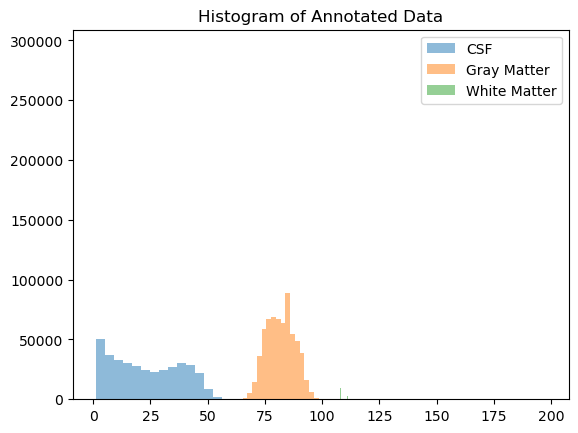

In [134]:
print(cluster_assignments)
plt.hist(data_matrix[cluster_assignments==1],bins=50,alpha=0.5)
plt.hist(data_matrix[cluster_assignments==2],bins=50,alpha=0.5)
plt.hist(data_matrix[cluster_assignments==3],bins=50,alpha=0.5)
plt.legend(["CSF","Gray Matter","White Matter"])
plt.title("Histogram of Annotated Data")
plt.show()

Global Variance :  916.7352904349542
Global Means :  [[103.02866925]
 [ 21.90757291]
 [ 72.05937156]]
[0.33333333 0.33333333 0.33333333]
Starting to fit


C:\Users\saira\AppData\Local\Temp\ipykernel_9188\3480137081.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.means[k] = np.sum(self.responsibilities[:,k].reshape(-1,1)*self.datapoints,axis=0)/n_k
C:\Users\saira\AppData\Local\Temp\ipykernel_9188\3480137081.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.stds[k] =np.sqrt(np.sum(self.responsibilities[:,k].reshape(-1,1)*(self.datapoints-self.means[k])**2,axis=0)/n_k)


Means : [76.9071213  76.81862309 76.8733631 ]
Stds : [30.25930301 30.2990685  30.27449079]
Magnitude of difference : 60.99781319062143
Epoch 0 done
Means : [76.92357067 76.79932045 76.87618849]
Stds : [30.24125454 30.32013961 30.27139565]
Magnitude of difference : 0.02551776059253525
Epoch 1 done
Means : [76.9562041  76.76102911 76.88179115]
Stds : [30.216032   30.34945112 30.2670613 ]
Magnitude of difference : 0.050621711437927014
Epoch 2 done
Means : [77.01140005 76.69625386 76.89127733]
Stds : [30.1763623  30.39525242 30.26022801]
Magnitude of difference : 0.0856295212272832
Epoch 3 done
Means : [77.10195941 76.58994788 76.90687257]
Stds : [30.11203254 30.4687734  30.24910643]
Magnitude of difference : 0.14051749990134993
Epoch 4 done
Means : [77.24954532 76.4166188  76.93237491]
Stds : [30.00674639 30.58714424 30.23079877]
Magnitude of difference : 0.22907410212659207
Epoch 5 done
Means : [77.48958096 76.13450421 76.97408604]
Stds : [29.83345846 30.77684291 30.20039024]
Magnitude o

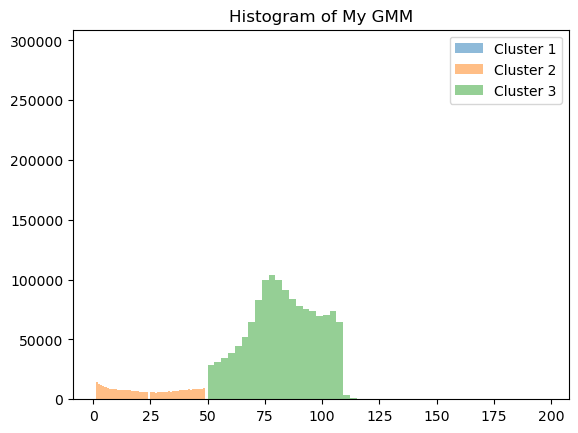

Did sklearn GMM converge : True
Number of iterations by SKlearn GMM : 24
[1 1 1 ... 1 1 1]
ARI Score: 1.0
My GMM Means : [109.83509168  25.46753555  83.3352604 ]
My GMM Stds : [ 0.37719626 17.40177802 15.86973167]
My GMM Weights : [0.16274902 0.18631612 0.65093486]
SKlearn GMM Means : [[109.82873577]
 [ 25.12132124]
 [ 83.18451707]]
SKlearn GMM Stds : [[[ 0.3837445 ]]

 [[17.17600271]]

 [[15.91418219]]]
SKlearn GMM Weights : [0.1641114  0.18412257 0.65176604]


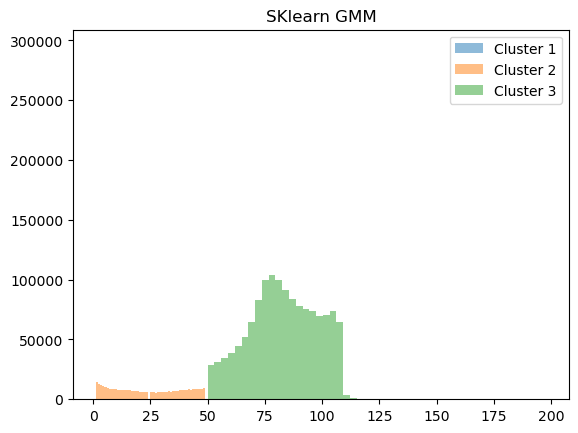

In [135]:
n_clusters = 3
gmm_instance = gmm(data_matrix,n_clusters)
gmm_instance.fit(threshold=1e-3)
print(gmm_instance.get_cluster_assignments())
gmm_instance.histogram()

## compare with sklearn GMM
from sklearn.mixture import GaussianMixture
sk_gmm = GaussianMixture(n_components=3)
sk_gmm.fit(data_matrix)
print(f"Did sklearn GMM converge : {sk_gmm.converged_}")
print(f"Number of iterations by SKlearn GMM : {sk_gmm.n_iter_}")
print(sk_gmm.predict(data_matrix))
from sklearn.metrics import adjusted_rand_score
print(f"ARI Score: {adjusted_rand_score(gmm_instance.get_cluster_assignments(),sk_gmm.predict(data_matrix))}")

## Compare Means and Variance of my GMM vs SKlearn GMM
print(f"My GMM Means : {gmm_instance.means}")
print(f"My GMM Stds : {gmm_instance.stds}")
print(f"My GMM Weights : {gmm_instance.weights}")
print(f"SKlearn GMM Means : {sk_gmm.means_}")
print(f"SKlearn GMM Stds : {np.sqrt(sk_gmm.covariances_)}")
print(f"SKlearn GMM Weights : {sk_gmm.weights_}")

## mean difference
plt.hist(data_matrix[sk_gmm.predict(data_matrix)==0],bins=50,alpha=0.5)
plt.hist(data_matrix[sk_gmm.predict(data_matrix)==1],bins=50,alpha=0.5)
plt.hist(data_matrix[sk_gmm.predict(data_matrix)==2],bins=50,alpha=0.5)
plt.title("SKlearn GMM")
plt.legend(["Cluster 1","Cluster 2","Cluster 3"])
plt.show()

In [136]:
## TRUE ARI
print(f"True ARI: {adjusted_rand_score(cluster_assignments,gmm_instance.get_cluster_assignments())}")
print(f"ARI with sklearn GMM : {adjusted_rand_score(cluster_assignments,sk_gmm.predict(data_matrix))}")
## Plotting the data

c:\Users\saira\anaconda3\envs\Pytorch\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


True ARI: 0.31915566472500784


c:\Users\saira\anaconda3\envs\Pytorch\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


ARI with sklearn GMM : 0.31915566472500784


In [137]:
print(data_matrix.shape)

(2123042, 1)


In [139]:
print(annotated_masks.sum())

2123042


(array([6.506357e+06, 2.000000e+01, 1.800000e+01, 1.900000e+01,
        0.000000e+00, 3.100000e+01, 2.500000e+01, 7.000000e+01,
        5.200000e+01, 7.000000e+01, 7.600000e+01, 7.100000e+01,
        1.170000e+02, 0.000000e+00, 1.280000e+02, 1.760000e+02,
        2.410000e+02, 4.160000e+02, 7.690000e+02, 7.870000e+02,
        1.692000e+03, 2.522000e+03, 2.602000e+03, 5.604000e+03,
        5.707000e+03, 1.073800e+04, 1.154400e+04, 8.112000e+03,
        1.349600e+04, 1.084200e+04, 9.692000e+03, 2.380600e+04,
        1.125200e+04, 1.235000e+04, 8.280000e+03, 1.151700e+04,
        9.878000e+03, 7.996000e+03, 1.129200e+04, 7.783000e+03,
        8.437000e+03, 9.622000e+03, 6.642000e+03, 9.244000e+03,
        7.751000e+03, 6.014000e+03, 8.743000e+03, 6.272000e+03,
        6.958000e+03, 7.358000e+03, 5.084000e+03, 7.475000e+03,
        6.143000e+03, 5.302000e+03, 6.839000e+03, 4.421000e+03,
        6.272000e+03, 5.093000e+03, 3.841000e+03, 5.342000e+03,
        2.538000e+03, 3.595000e+03, 2.39

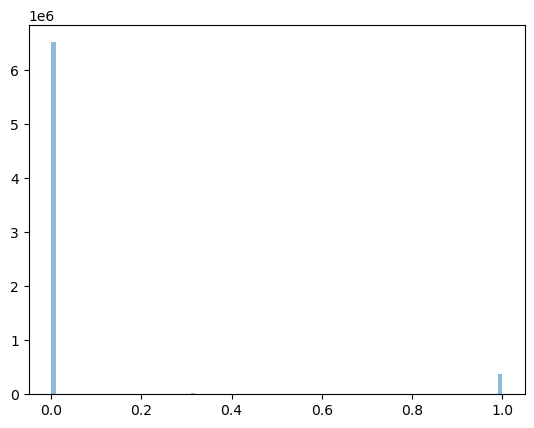

In [145]:
plt.hist(csf_mask.flatten(),bins=100,alpha=0.5)